# Tracking Adults

This notebook (presented to the Smart Cities Expo -- http://smartcitiesexpoworldforum.com/conference-programme/ ) demonstrates a method of tracking adults coming to a location.

Almost every adult carries a mobile phone and has wifi turned on. There are exceptions -- particularly among the
elderly -- but this gives us a quick first pass.

Wifi devices broadcast every few seconds to probe for wifi access points. This is sent with a unique id associated
with the phone. Some iphones and ipads under just the right circumstances will randomise this: almost nothing else
does, and most iphones don't either.

It's easy enough to capture this information, if slightly creepy. Slightly less creepy is to set up a genuine
"guest" wifi network and let people connect to this.

Either way, you will end up with a list of unique ids (macaddresses) and you can count the number of people in 
a location and also how often the return

In [1]:
%matplotlib inline
import pandas
import seaborn
import matplotlib
import matplotlib.dates
import numpy

import datetime
def date_parser(x):
    return datetime.datetime.strptime(x, "%b %d %H:%M:%S").replace(year=2016)

def round_to_quarter_hour(n):
    return round(n * 24 * 4) / (24 * 4)

The following cell shows a syslog dump from a guest wifi network.

In [2]:
print open('dhcpd-dump.txt').read()

Dec 10 23:06:48 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.21 from 1c:1a:c0:92:43:7a via re0
Dec 10 23:08:51 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.227 from c0:ce:cd:c0:23:2f via re0
Dec 10 23:16:40 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.21 from 1c:1a:c0:92:43:7a via re0
Dec 10 23:26:11 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.166 from 00:28:ac:32:45:26 via re0
Dec 10 23:26:35 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.21 from 1c:1a:c0:92:43:7a via re0
Dec 10 23:31:20 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.143 from 80:3f:5d:09:dc:8c via re0
Dec 10 23:33:48 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.143 from 80:3f:5d:09:dc:8c via re0
Dec 10 23:36:30 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.21 from 1c:1a:c0:92:43:7a via re0
Dec 10 23:45:30 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.143 from 80:3f:5d:09:dc:8c via re0
Dec 10 23:46:26 guestgw dhcpd[10056]: DHCPREQUEST for 10.1.91.21 from 1c:1a:c0:92:43:7a via re0
Dec 10 23:56:16 guestgw dhcpd[10056

We do the usual sorts of manipulations to get it into a form that standard libraries can manipulate

In [3]:
rawtext = pandas.read_csv('dhcpd-dump.txt', names=['rawtext'])
phones = rawtext.rawtext.str.extract('([A-Z][a-z][a-z] *\d+ \d+:\d+:\d+).*DHCPREQUEST.*from ([a-f0-9:]{17})', expand=True)
phones.columns = ['date_str','phone']
phones['date'] = phones.date_str.map(date_parser)
del phones['date_str']
phones

,phone,date
0,1c:1a:c0:92:43:7a,2016-12-10 23:06:48
1,c0:ce:cd:c0:23:2f,2016-12-10 23:08:51
2,1c:1a:c0:92:43:7a,2016-12-10 23:16:40
3,00:28:ac:32:45:26,2016-12-10 23:26:11
4,1c:1a:c0:92:43:7a,2016-12-10 23:26:35
5,80:3f:5d:09:dc:8c,2016-12-10 23:31:20
6,80:3f:5d:09:dc:8c,2016-12-10 23:33:48
7,1c:1a:c0:92:43:7a,2016-12-10 23:36:30
8,80:3f:5d:09:dc:8c,2016-12-10 23:45:30
9,1c:1a:c0:92:43:7a,2016-12-10 23:46:26


In [4]:
lookup = dict(zip(list(phones.phone.unique()), range(1,50)))
phones['phone_id'] = phones.phone.map(lookup.get)
phones['day'] = phones.date.map(matplotlib.dates.date2num)
phones['quarter_hour'] = phones.day.map(round_to_quarter_hour)
phones

,phone,date,phone_id,day,quarter_hour
0,1c:1a:c0:92:43:7a,2016-12-10 23:06:48,1,736308.963056,736308.958333
1,c0:ce:cd:c0:23:2f,2016-12-10 23:08:51,2,736308.964479,736308.968750
2,1c:1a:c0:92:43:7a,2016-12-10 23:16:40,1,736308.969907,736308.968750
3,00:28:ac:32:45:26,2016-12-10 23:26:11,3,736308.976516,736308.979167
4,1c:1a:c0:92:43:7a,2016-12-10 23:26:35,1,736308.976794,736308.979167
5,80:3f:5d:09:dc:8c,2016-12-10 23:31:20,4,736308.980093,736308.979167
6,80:3f:5d:09:dc:8c,2016-12-10 23:33:48,4,736308.981806,736308.979167
7,1c:1a:c0:92:43:7a,2016-12-10 23:36:30,1,736308.983681,736308.979167
8,80:3f:5d:09:dc:8c,2016-12-10 23:45:30,4,736308.989931,736308.989583
9,1c:1a:c0:92:43:7a,2016-12-10 23:46:26,1,736308.990579,736308.989583


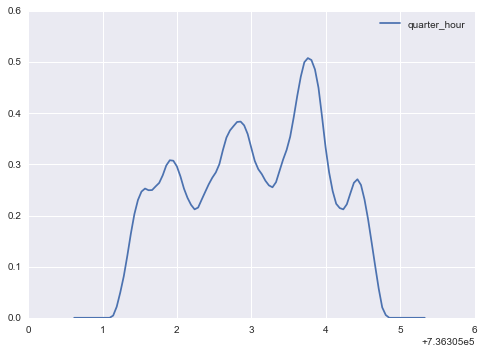

In [5]:
seaborn.kdeplot(phones.quarter_hour, kernel='cos')

How many distinct phones did we see?

In [6]:
phones.phone.nunique()

28

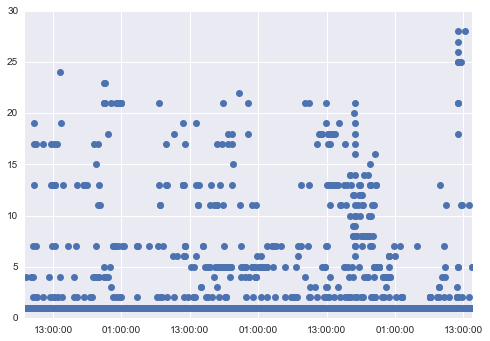

In [7]:
matplotlib.pyplot.plot_date(x=phones.day, y=phones.phone_id, xdate=True)